# Non-Negative Matrix Factorization

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

# Preprocessing

In [2]:
data = pd.read_pickle("../4_2_DiscriminativeClassifers/data/articles.pkl")

In [3]:
import ftfy
data['content'] = data['content'].apply(lambda x: ftfy.fix_text(x)
                                        if isinstance(x, unicode)
                                        else "Warning: not Unicode")

data = data[data['content'] != "Warning: not Unicode"]
print("{} row isn't unicode".format(sum(data['content'] == "Warning: not Unicode")))

0 row isn't unicode


# Section Names

In [4]:
vectLabel = LabelEncoder()
y = vectLabel.fit_transform(data.section_name)

for section in vectLabel.classes_:
    print vectLabel.transform(section), ":",section

0 : Arts
1 : Books
2 : Business Day
3 : Magazine
4 : Opinion
5 : Real Estate
6 : Sports
7 : Travel
8 : U.S.
9 : World


In [5]:
X = data.content
vect = TfidfVectorizer(max_df=0.99,
                        min_df=2,
                        max_features=5000,
                        stop_words='english')

X_vect = vect.fit_transform(X).toarray()

feature_names = vect.get_feature_names()

# Euclidean Distance

We want to aproximate:

$$V \simeq HW$$
We'll be using two algorithm described in the paper [Algorithms for Non-negative Matrix
Factorization](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.31.7566&rep=rep1&type=pdf) by *Daniel D. Lee Bell Laboratories* and *H. Sebastian Seung, MIT*.

The first one will be the square of the Euclidean distance between $V$ and $HW$:

![](images/Euclidean1.png)
![](images/Euclidean2.png)

# Divergense

Divergence between two distributions lower bounded by zero, and vanishes if and only
if A = B. It doesn't really represent a "distance" because it is not symmetric. If the matrix are normalized this simplify to the Kullback-Leibler divergence, or relative entropy.


![](images/Divergense1.png)
![](images/Divergense2.png)

![](images/KL-Gauss-Example.png)

In [6]:
class NNegativeMatrixFactorization():
    def __init__(self, V, n_topics):
        self.V = V
        
        self.numDoc, self.numWord = V.shape
        self.numTopic = n_topics
        
        self.H = np.random.rand(self.numDoc, self.numTopic)
        self.W = np.random.rand(self.numTopic, self.numWord)
        
        self.cost_list = []
        
    def cost(self):
        V_hat = self.H.dot(self.W)
        return np.linalg.norm(self.V - V_hat)**2
    
    def costDivergence(self):
        V_hat = self.H.dot(self.W)
        return np.sum(self.V * np.log(self.V / V_hat) - self.V + V_hat)
    
    def EuclideanDistance(self, num_iterations):
        for _ in xrange(num_iterations):
            self.W *= self.H.T.dot(self.V) / self.H.T.dot(self.H).dot(self.W)
            self.H *= self.V.dot(self.W.T) / self.H.dot(self.W).dot(self.W.T)
            self.cost_list.append(self.cost())
            
    
    def Divergence(self, num_iterations):
        for _ in xrange(num_iterations):
            for k in xrange(self.numTopic):
                for w in xrange(self.numWord):
                    self.W[k,w] *= sum(self.H[:,k] * self.V[:,w] /
                                       self.H.dot(self.W)[:,w]) / sum(self.H[:,k])
                    
                for d in xrange(self.numDoc):
                    self.H[d,k] *= sum(self.W[k,:] * self.V[d,:] /
                                       self.H.dot(self.W)[d,:]) / sum(self.W[k,:])
      
            self.cost_list.append(self.costDivergence())

    def run(self, num_iterations, update_type = "euclidean"):
        if update_type == "euclidean":
            self.EuclideanDistance(num_iterations)
        elif update_type == "divergence":
            self.Divergence(num_iterations)
            
    def clusters(self, n_top_words, n_top_topics):
        docs = np.argsort(self.H, 0)[::-1, :n_top_topics]
        words = np.argsort(self.W, 1)[::-1, :n_top_words]
        return docs, words

In [7]:
NMF = NNegativeMatrixFactorization(X_vect, n_topics = 10)
NMF.run(num_iterations = 80, update_type = "euclidean")
Euclidean_cost = NMF.cost_list
Edocs, Ewords = NMF.clusters(n_top_words = 10, n_top_topics = 10)

In [8]:
# NMF = NNegativeMatrixFactorization(X_vect, n_topics = 10)
# NMF.run(num_iterations = 80, update_type = "divergence")
# Divergence_cost = NMF.cost_list
# Ddocs, Dwords = NMF.clusters(n_top_words = 10, n_top_topics = 3)

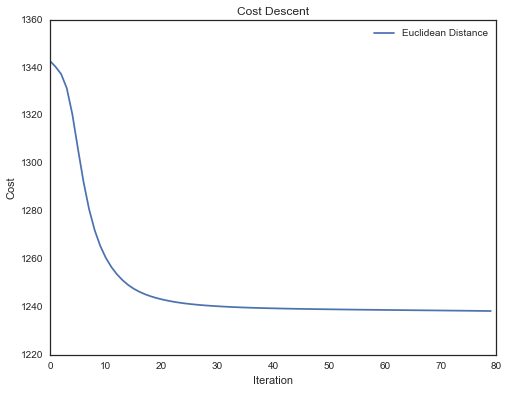

In [9]:
plt.plot(xrange(len(Euclidean_cost)), Euclidean_cost)
#plt.plot(xrange(len(Divergence_cost)), Divergence_cost)
plt.legend(["Euclidean Distance", "Divergence"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Descent");

In [10]:
for topic_idx, words in enumerate(Ewords):
    print("Topic #{}:".format(topic_idx + 1))
    print(", ".join([feature_names[i] for i in words]))
    print("")

Topic #1:
clemens, baradar, mccutcheon, medicaid, gbagbo, sadr, snee, baa, brewer, punt

Topic #2:
zorn, violin, cello, magritte, mandala, typhoon, philharmonic, balthus, promoter, bp

Topic #3:
zorn, magritte, ncis, onegin, clemens, philharmonic, balthus, vampire, cello, tharp

Topic #4:
magritte, tharp, oriole, athens, balanchine, drake, capuano, mclaren, clemens, freddie

Topic #5:
zorn, balthus, philharmonic, magritte, tharp, volkswagen, gilligan, drake, koch, ballad

Topic #6:
baradar, fallon, berlusconi, clemens, letta, onegin, kenyatta, jamal, homered, philharmonic

Topic #7:
philharmonic, onegin, balthus, tharp, zorn, magritte, vampire, gala, melody, gilbert

Topic #8:
sadr, kenyatta, clemens, baradar, gbagbo, peshawar, hague, islamabad, tharp, baghdad

Topic #9:
clemens, oriole, touchdown, longoria, waiver, brewer, tannehill, vaccine, strikeout, snee

Topic #10:
baradar, gbagbo, sadr, kenyatta, tharp, vs, tannehill, interception, peshawar, fumble



In [11]:
for topic_idx, docs in enumerate(Edocs[:10]):
    print("Doc #{}:".format(topic_idx + 1))
    print(", ".join([feature_names[i] for i in docs]))
    print("")

Doc #1:
collective, art, bos, buried, definition, destruction, damascus, 53, designer, acknowledged

Doc #2:
compelling, bid, commentator, challenge, detention, big, devil, 20th, baltimore, caused

Doc #3:
barred, beginning, destination, concerning, announce, award, desire, actually, 82, backing

Doc #4:
control, citizen, counterterrorism, converted, biological, badly, carter, daughter, arrive, bruce

Doc #5:
armed, believe, core, block, april, cultural, demonstrated, clothing, alitalia, crucial

Doc #6:
british, culture, alcohol, command, busy, bathroom, attacked, causing, devoted, class

Doc #7:
born, aimed, affair, 2010, based, active, 1913, buffalo, 1998, concluded

Doc #8:
attacking, competition, 70, clubhouse, artist, box, americans, 1996, denver, commissioned

Doc #9:
baghdad, cohen, cleared, assume, agreement, 1992, aren, destructive, cutting, breakfast

Doc #10:
angel, aircraft, buying, briefly, destroy, car, appreciate, automobile, cycle, athens

